## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps (spowolnienie ok. 1:7.5) zostało przekodowane tak, aby osiągnąć zbieżność upływu czasu. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem.

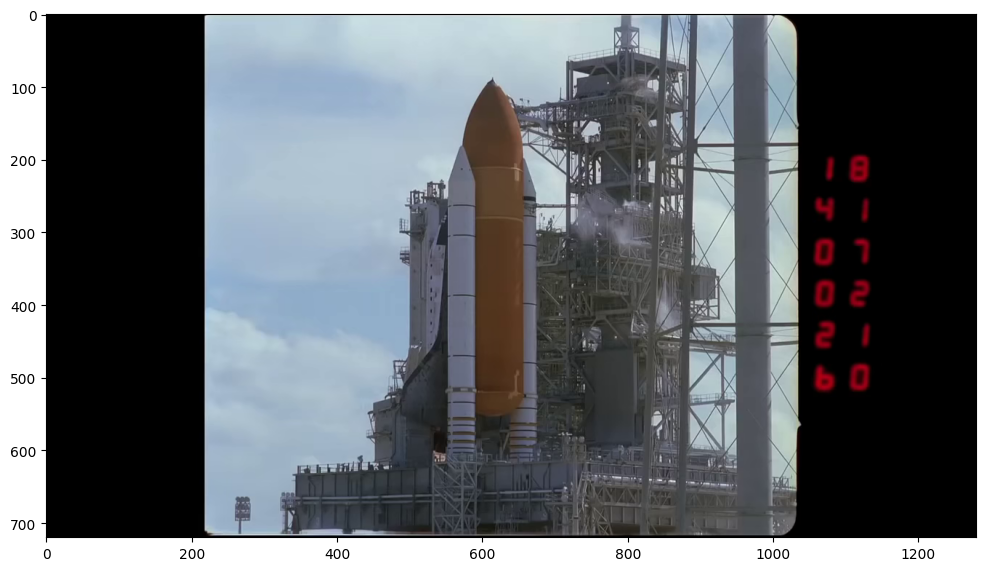

In [2]:
source = cv2.VideoCapture('shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

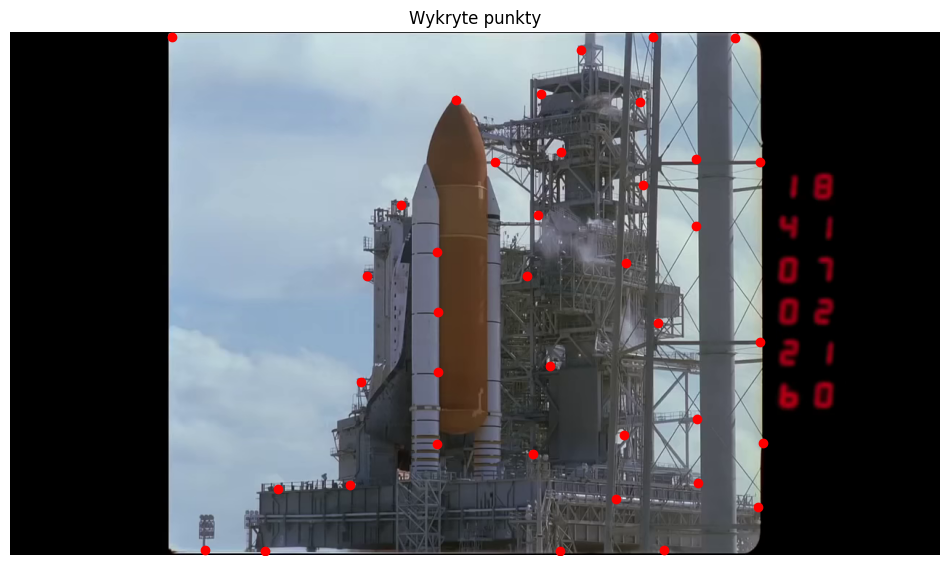

In [3]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

feature_params = dict(maxCorners=100, qualityLevel=0.1, minDistance=80, blockSize=10)

p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
if p0 is not None:
    for x, y in np.float32(p0).reshape(-1, 2):
        plt.scatter(x, y, color='red')
plt.title('Wykryte punkty')
plt.axis('off')
plt.show()


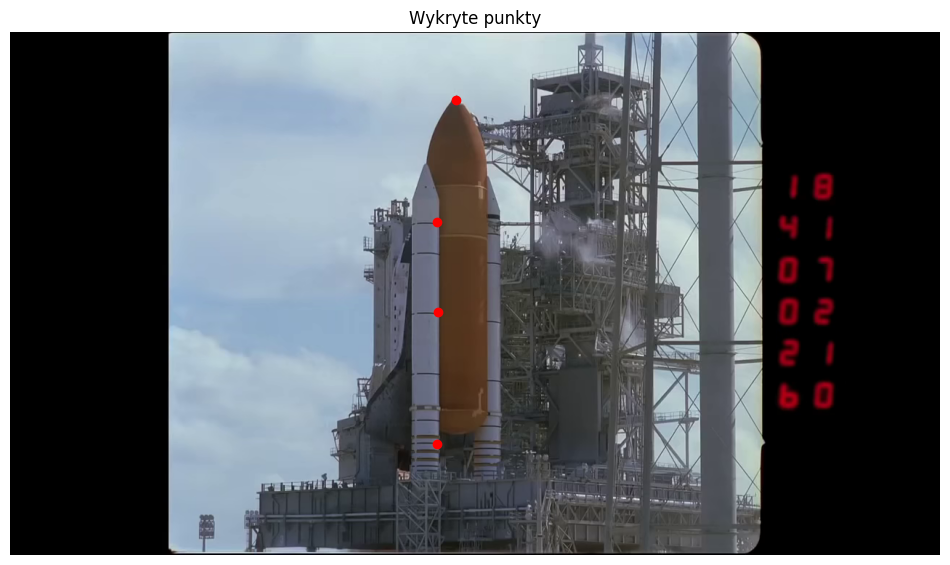

In [8]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

x_margin_left = 550 
x_margin_right = 610 
height, width = gray.shape

mask = np.zeros_like(gray)
mask[:, x_margin_left:width - x_margin_right] = 255

feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=110, blockSize=10)

p0 = cv2.goodFeaturesToTrack(gray, mask=mask, **feature_params)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
if p0 is not None:
    for x, y in np.float32(p0).reshape(-1, 2):
        plt.scatter(x, y, color='red')
plt.title('Wykryte punkty')
plt.axis('off')
plt.show()

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [16]:
import cv2
import numpy as np

def baseLoop(source: cv2.VideoCapture):
    _, frame1 = source.read()
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    _, width = gray1.shape

    x_margin_left = 550
    x_margin_right = 620

    gray_cropped = gray1[:, x_margin_left:width - x_margin_right]

    feature_params = dict(maxCorners=100, qualityLevel=0.2, minDistance=100, blockSize=10)
    p0 = cv2.goodFeaturesToTrack(gray_cropped, mask=None, **feature_params)
    mask = np.zeros_like(frame1[:, x_margin_left:width - x_margin_right])

    tracked_points = []
    good_new = 1
    while True:
        status, frame2 = source.read()
        if not status:
            break
        
        frame_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        frame_gray_cropped = frame_gray[:, x_margin_left:width - x_margin_right]

        p1, st, err = cv2.calcOpticalFlowPyrLK(gray_cropped, frame_gray_cropped, p0, None, winSize=(15, 15), maxLevel=2)

        if p1 is None:
            break

        good_new = p1[st == 1]
        good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame2 = cv2.circle(frame2, (int(a) + x_margin_left, int(b)), 5, (0, 0, 255), -1)
            tracked_points.append((old, new))

        full_mask = np.zeros_like(frame1)
        full_mask[:, x_margin_left:width - x_margin_right] = mask

        img = cv2.add(frame2, full_mask)

        gray_cropped = frame_gray_cropped.copy()
        p0 = good_new.reshape(-1, 1, 2)

        cv2.imshow('Trajektorie', img)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

    cv2.destroyAllWindows()
    source.release()

    return tracked_points

source = cv2.VideoCapture('shuttle.mp4')
tracked_points = baseLoop(source)

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_. Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością. Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.

_Bonus dla chętnych: czy na podstawie tego materiału da się wyznaczyć TWR (thrust-to-weight ratio) maszyny?_

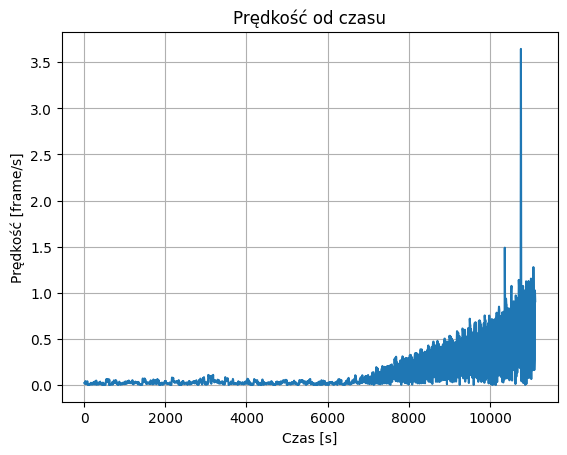

In [17]:
def calculate_velocity(tracked_points, frame_rate):
    velocities = []

    for i in range(1, len(tracked_points)):
        old_point, new_point = tracked_points[i][0], tracked_points[i][1]
        displacement = np.linalg.norm(new_point - old_point)

        time_interval = 1 / frame_rate

        velocity = displacement / time_interval

        velocities.append(velocity)

    return velocities

frame_rate = 1/7.5

velocities = calculate_velocity(tracked_points, frame_rate)

time_stamps = np.arange(1, len(tracked_points)) / frame_rate
plt.plot(time_stamps, velocities)
plt.xlabel('Czas [s]')
plt.ylabel('Prędkość [frame/s]')
plt.title('Prędkość od czasu')
plt.grid(True)
plt.show()